# Table of contents
1. [Introduction](#introduction)
2. [Import](#import)
3. [Data preprocessing](#preprocess)
    1. [Missing values](#subpreprocess)
4. [Correlation with dependent variable](#correlation_dependent)
5. [Feature engineering](#feature_engineering)
    1. [One-hot encoding](#one-hot)
6. [Importance of variables](#importance)
    1. [Correlation between variables with highest importance score](#correlation_importance)
    2. [Variables selection](#variables_selection)
7. [Scaling data](#scaling)
8. [Train-test split](#train_test)
9. [Base estimator - linear regression](#base_estimator)
10. [Xgboost](#xgboost)

## This is the introduction <a name="introduction"></a>

## Importing packages and data <a name="import"></a>

In [1]:
import pandas as pd
import numpy as np
import os
import scipy as sp
import matplotlib
matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import warnings
from utils import plot_learning_curve
%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

In [78]:
import pickle
from utils import plot_learning_curve

Changing the fontisize for all graphs so that everything is (hopefully) clearly visible

In [4]:
font = {'size'   : 15}

matplotlib.rc('font', **font)

In [5]:
data_house = pd.read_csv('train.csv')

## Data preprocessing <a name="preprocess"></a>
The first paragraph text

### Missing values <a name="subpreprocess"></a>
This is a sub paragraph, formatted in heading 3 style

Check on the missing values

In [6]:
missing = data_house.isnull().sum().sort_values(ascending=False)
percent = data_house.isnull().sum()/data_house.isnull().count().sort_values(ascending=False)
data_missing = pd.concat([missing, percent], axis=1, keys=['Total', 'Percent']).sort_values(by='Total', ascending=False)
print(data_missing.head(6))

             Total   Percent
PoolQC        1453  0.995205
MiscFeature   1406  0.963014
Alley         1369  0.937671
Fence         1179  0.807534
FireplaceQu    690  0.472603
LotFrontage    259  0.177397


Plot missing variables in descending order, results are shown only for those variables that do possess some NaNs

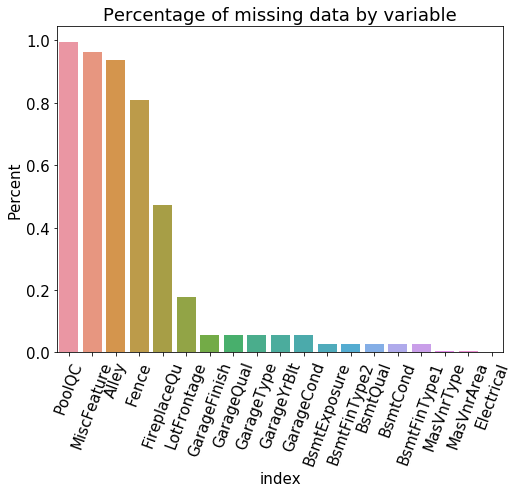

In [7]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6))
sns.barplot(data=data_missing[data_missing['Percent'] >0].reset_index(), x = 'index', 
            y='Percent')
plt.xticks(rotation=70)
plt.title("Percentage of missing data by variable")
plt.show()

Drop variables when more than 90% of data is missing

In [8]:
data_house.drop(data_missing[data_missing['Percent']>0.7].index,1, inplace=True)

Based on description file.txt most of the missing data in variables such as Fence, Garage or Bsmt connected variables
are due to the lack of fence, garage etc. Due ot this fact we can fill NA in those variables with new category (since they are categorical variables)
For the data that is numeric the filled values are equal to zero - also due to the fact that apparent absence of values of these variables is connected with missing data

In [9]:
data_house.loc[:,data_house.columns.str.contains
("Garage|Bsmt|Fence|MasVnrType|Electrical|FireplaceQu")] =data_house.loc[:,
data_house.columns.str.contains("Garage|Bsmt|Fence|MasVnrType|Electrical|FireplaceQu")].fillna("MISSING")
data_house.loc[:,["MasVnrArea", "LotFrontage"]] = data_house.loc[:,["MasVnrArea", "LotFrontage"]].fillna(0)

Distribution of the target variable

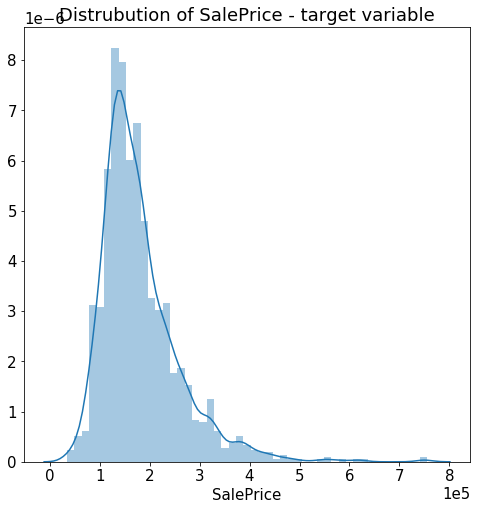

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


In [10]:
fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(data_house['SalePrice'])
ax.set_title("Distrubution of SalePrice - target variable")
ax.ticklabel_format(style='scientific', axis='both', scilimits=(-3,3))
plt.show()
skew = data_house['SalePrice'].skew()
kurt = data_house['SalePrice'].kurt()
print(f'Skewness: {skew}\nKurtosis: {kurt}')

Fiew visualisations to show basic relationships and statistics

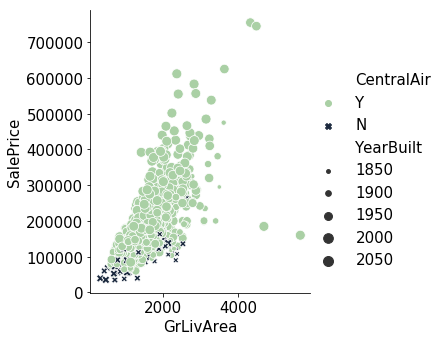

In [11]:
sns.relplot(x = 'GrLivArea', y = 'SalePrice', hue = 'CentralAir', style='CentralAir', 
            palette= "ch:r=-.5,l=0.75", size="YearBuilt", sizes=(15,100), data = data_house)
plt.show()

We can see that there are outliers present, with GrLivArea higher than 4000 square feet
<br>
They can be removed without further ado


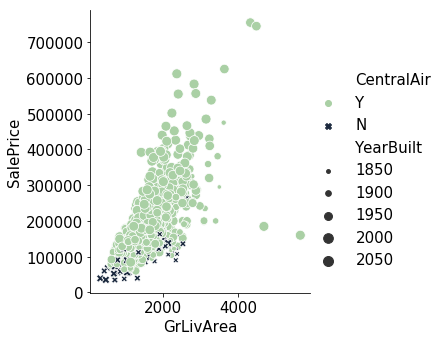

In [12]:
sns.relplot(x = 'GrLivArea', y = 'SalePrice', hue = 'CentralAir', style='CentralAir', 
            palette= "ch:r=-.5,l=0.75", size="YearBuilt", sizes=(15,100), data = data_house)
plt.show()

In [13]:
data_house = data_house[data_house['GrLivArea'] <4000]

Show average SalePrice by year

In [14]:
data_mean = data_house.groupby(by='YearBuilt').agg('mean')
data_mean.reset_index(inplace=True)

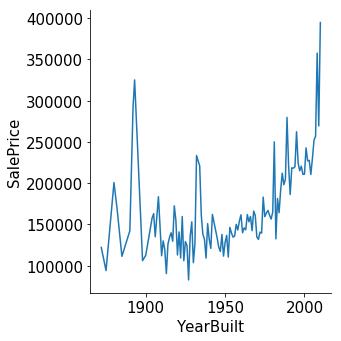

In [15]:
sns.relplot(x='YearBuilt', y = 'SalePrice', kind='line', data=data_mean)
plt.show()

Show the same data but this time with standard deviation

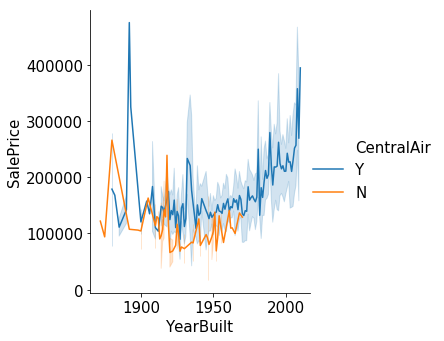

In [16]:
g = sns.relplot(x='YearBuilt', y = 'SalePrice', kind='line', ci='sd', estimator = 'mean',
            hue = 'CentralAir',data=data_house)
plt.show()

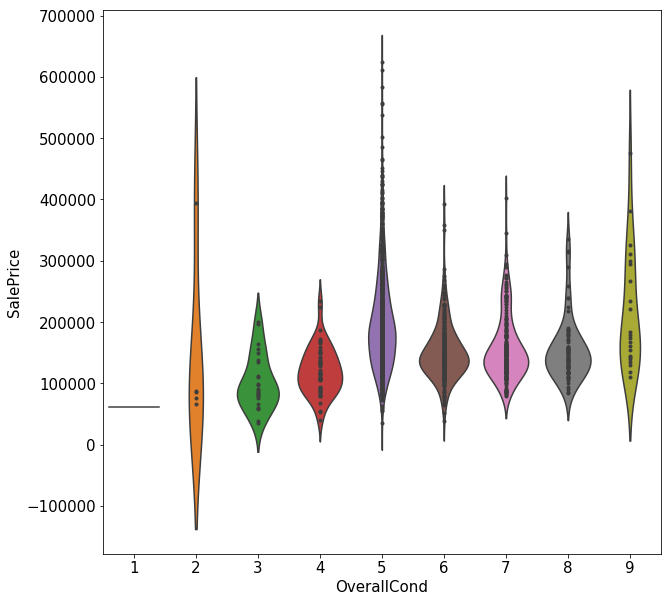

In [17]:
fig, ax = plt.subplots(figsize = (10,10))
sns.violinplot(data=data_house, y='SalePrice', x='OverallCond', ax=ax, inner='points')
plt.show()

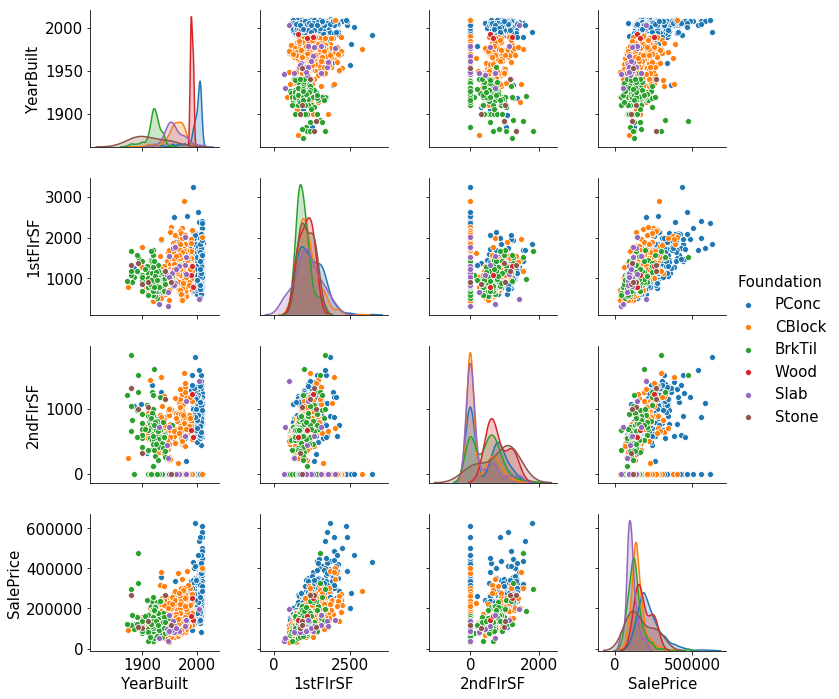

In [18]:
sns.pairplot(data=data_house, x_vars=['YearBuilt','1stFlrSF', '2ndFlrSF','SalePrice'],
             y_vars=['YearBuilt','1stFlrSF', '2ndFlrSF','SalePrice'], hue='Foundation')
plt.show()

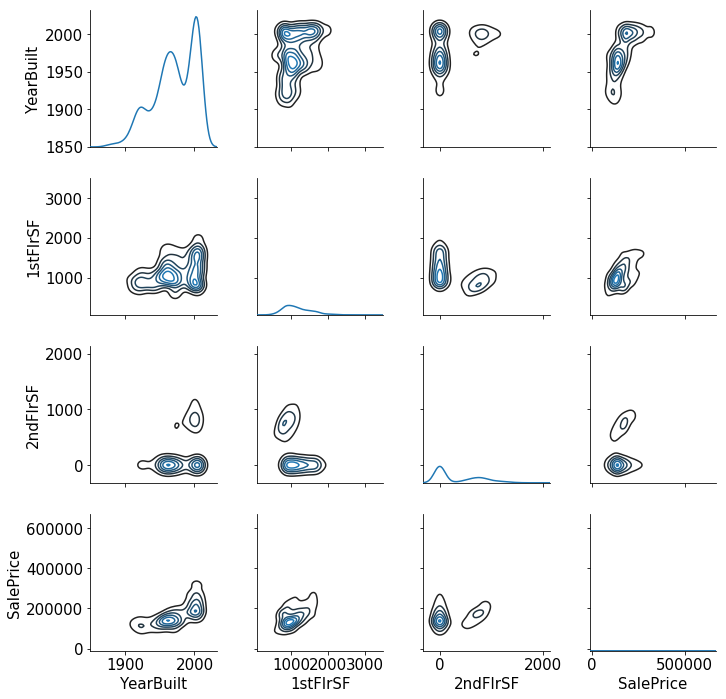

In [19]:
g = sns.PairGrid(data_house,x_vars=['YearBuilt','1stFlrSF', '2ndFlrSF','SalePrice'],
             y_vars=['YearBuilt','1stFlrSF', '2ndFlrSF','SalePrice'])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

One can easily spot changes in the type of materials used to build houses throughout given time period.

Now it's time to check correlations between dependent variable and the rest

### Correlation with dependent variable <a name="correlation_dependent"></a>

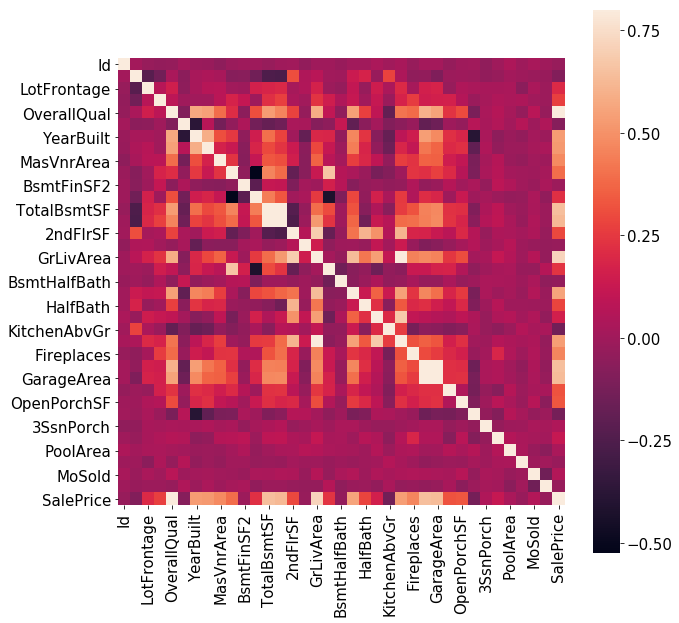

In [20]:
corrmat = data_house.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=corrmat, vmax=.8, square=True)
plt.show()

Print only 10 mostly correlated variables

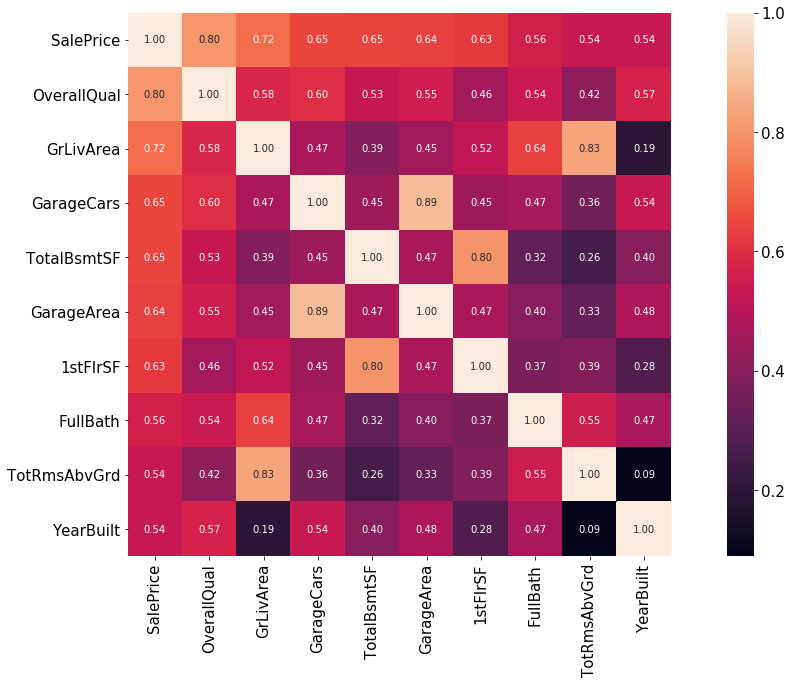

In [21]:
fig, ax = plt.subplots(figsize=(20,10))
cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
corr10 = data_house.loc[:, cols].corr()
sns.heatmap(data=corr10, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.show()

### Feature engineering <a name="feature_engineering"></a>

It's reasonable to define Age variable instead of YearBuilt, since during scaling year differences
<br>
would be insignificant compared to differences in house ages
<br>
since the newest records are from year 2010, I'm going to assume that the dataset is from 2011 and based on that 
calculate the Age variable

In [22]:
data_house['Age'] = 2011 - data_house['YearBuilt']

### One-hot encoding <a name="one-hot"></a>

One-hot encoding of the character variables
<br>
Semicolon added to surpress output

In [23]:
pd.get_dummies(data_house.select_dtypes('object'));
data_house_one_hot = pd.concat([data_house.select_dtypes(['int','float']),
                                pd.get_dummies(data_house.select_dtypes('object'))], axis=1)

### Importance of variables <a name="importance"></a>

Importance selection based on RandomForest result and one-hot encoded data

In [24]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42)

In [25]:
X_rf = data_house_one_hot.columns.isin(["SalePrice","Id"])
rf.fit(X=data_house_one_hot.loc[:, ~X_rf], 
       y = data_house_one_hot.loc[:,"SalePrice"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [26]:
importances = pd.concat([pd.Series(data_house_one_hot.columns[~X_rf]),
                         pd.Series(rf.feature_importances_)], axis=1)

In [27]:
importances_dict = dict(zip(data_house_one_hot.columns[~X_rf],rf.feature_importances_))

In [28]:
importances.columns = ['Feature', "Importance"]
importances_sorted = importances.sort_values(by="Importance",ascending=False)

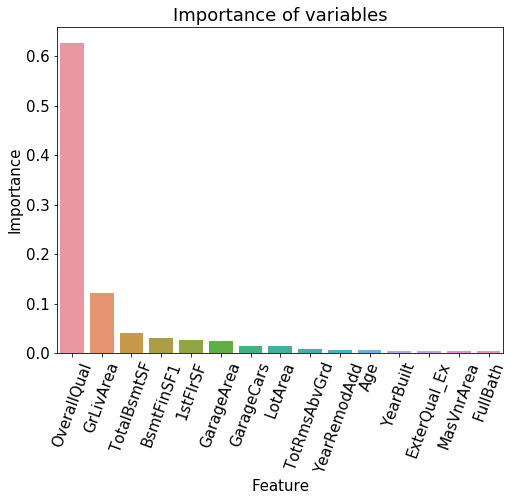

In [29]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6))
sns.barplot(data=importances_sorted.iloc[:15,:],
            x = "Feature",
            y='Importance')
plt.xticks(rotation=70)
plt.title("Importance of variables")
plt.show()

Calculate correlation matrix between 15 variables with highest importance from randomforest

### Correlation between variables with highest importance score <a name="correlation_importance"></a>

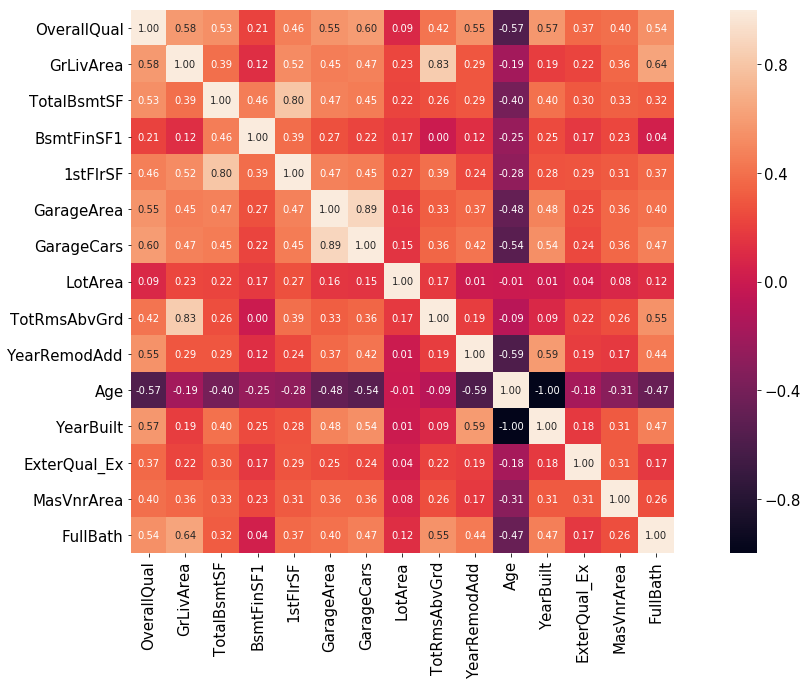

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
correlations = data_house_one_hot.loc[:,importances_sorted.iloc[:15,:]['Feature']].corr()
sns.heatmap(correlations, annot=True, square=True,
           fmt='.2f', annot_kws = {'size': 10})

### Variables selection <a name="variables_selection"></a>

Select only pairs with higher correlation than threshold given in np.triu function

In [31]:
corr_matrix = correlations.abs()
index_names = corr_matrix.index
col_names = corr_matrix.columns
arr = corr_matrix.values
R,C = np.where(np.triu(arr,1)>0.7)

# Arrange those in columns and put out as a dataframe
out_arr = np.column_stack((index_names[R],col_names[C],arr[R,C]))
df_out = pd.DataFrame(out_arr,columns=[['row_name','col_name','value']])

Select columns to drop from the list of 15 most important from random forest that are correalted
<br>
more than threshold given in previous cell

In [32]:
cols_to_drop = []
for var in out_arr:
    temp = dict( (k,importances_dict[k]) for k in [var[0],var[1]] if k in importances_dict.keys())
    cols_to_drop.append(min(temp, key=temp.get))

In [33]:
variables = corr_matrix.columns.drop(cols_to_drop)

Define data with selected variables

In [34]:
data_house_selected = pd.concat([data_house_one_hot.loc[:,variables], data_house['SalePrice']], axis=1)

### Scaling data <a name="scaling"></a>

In [35]:
minmax = MinMaxScaler()
minmax.fit(data_house_selected)
data_house_selected_norm = pd.DataFrame(minmax.transform(data_house_selected), index=data_house_selected.index,
                                        columns=data_house_selected.columns)

/Users/lukaszbala/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Train-test split <a name="train_test"></a>

Split train.csv into test and dev set to see how the model is doing directly

In [36]:
data_house_selected_norm_x = data_house_selected_norm.loc[:,~data_house_selected_norm.columns.isin(['SalePrice'])]
train_x, dev_x, train_y, dev_y = train_test_split(data_house_selected_norm_x, 
                                                  data_house_selected_norm['SalePrice'], 
                                                    test_size=0.2, random_state=42)

### Base estimator - linear regression <a name="base_estimator"></a>

In [37]:
lr = LinearRegression()
lr.fit(train_x, train_y)
lr_pred = lr.predict(dev_x)
print(np.sqrt(mean_squared_error(y_pred=lr_pred, y_true=dev_y)))

0.04678890770434552


<module 'matplotlib.pyplot' from '/Users/lukaszbala/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

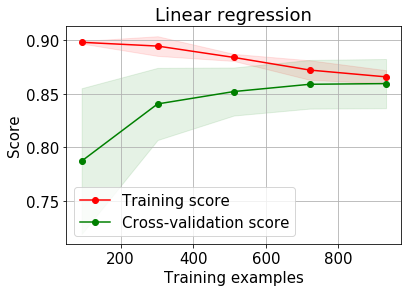

In [82]:
plot_learning_curve(X=train_x, y = train_y, estimator=lr, cv=5, title="Linear regression")

### Xgboost <a name='xgboost'></a>

Using xgboost and comparing without and with hyperopt

In [39]:
dtrain = xgb.DMatrix(train_x, label=train_y)
ddev = xgb.DMatrix(dev_x, label=dev_y)

In [40]:
param = {'objective': 'reg:linear', 'eval_metric': 'rmse', 'base_score' : 0.5, 'booster' : 'gbtree', 
         'colsample_bylevel' : 1, 'colsample_bytree':1, 'learning_rate':0.1, 'max_delta_step':0,
         'min_child_weight':1, 'missing':None, 'n_estimators':100,
       'n_jobs':1, 'random_state':0,
       'reg_alpha':0, 'reg_lambda':1, 'scale_pos_weight':1,
       'silent':True, 'subsample':1, 'seed':42}
evallist = [(ddev, 'eval'), (dtrain, 'train')]
num_round=1000

In [41]:
bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=200)

[0]	eval-rmse:0.261618	train-rmse:0.256824
[200]	eval-rmse:0.043059	train-rmse:0.0065
[400]	eval-rmse:0.04297	train-rmse:0.00228
[600]	eval-rmse:0.042946	train-rmse:0.002029
[800]	eval-rmse:0.042946	train-rmse:0.002029
[999]	eval-rmse:0.042946	train-rmse:0.002029


In [42]:
xgbregr = xgb.XGBRegressor(seed=42)
xgbregr.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [43]:
pred = xgbregr.predict(dev_x)

In [44]:
pred2 = bst.predict(ddev)

Results without hyperopt - XGBRegressor and xgb.train compared

In [45]:
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=dev_y)))
print(np.sqrt(mean_squared_error(y_pred=pred2, y_true=dev_y)))

0.04131356630872501
0.04294602714136356


<module 'matplotlib.pyplot' from '/Users/lukaszbala/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

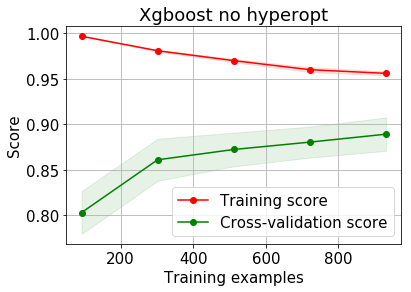

In [84]:
plot_learning_curve(X=train_x, y = train_y, estimator=xgbregr, cv=5, title="Xgboost no hyperopt")

Defining objective function and range for some parametrs to be used in hyperopt

In [47]:
def objective(space):
    print(space)
    clf = xgb.XGBRegressor(n_estimators =1000,colsample_bytree=space['colsample_bytree'],
                           learning_rate = .3,
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                           gamma = space['gamma'],
                           reg_lambda = space['reg_lambda'])

    eval_set  = [( train_x, train_y), ( dev_x, dev_y)]

    clf.fit(train_x, train_y,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = clf.predict(dev_x)
    mse_scr = mean_squared_error(dev_y, pred)
    #change the metric if you like
    return {'loss':mse_scr, 'status': STATUS_OK }


space ={'max_depth': hp.quniform("x_max_depth", 1, 13, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.4,1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1),
        'colsample_bylevel': hp.uniform('x_colsample_bylevel',0.4,1),
        'colsample_bynode' : hp.uniform('x_colsample_bynode',0.4,1),
        'reg_alpha': hp.uniform('x_reg_alpha',0,1)
        
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=1000,
            trials=trials)

{'colsample_bylevel': 0.9609930018206927, 'colsample_bynode': 0.9863845739593445, 'colsample_bytree': 0.7414137923216748, 'gamma': 0.3881797255314677, 'max_depth': 2.0, 'min_child_weight': 4.0, 'reg_alpha': 0.17649783850591927, 'reg_lambda': 0.7334967156621545, 'subsample': 0.7331216883306523}
{'colsample_bylevel': 0.4954791912285247, 'colsample_bynode': 0.6375245336496317, 'colsample_bytree': 0.8250358506262823, 'gamma': 0.41969883026409616, 'max_depth': 4.0, 'min_child_weight': 1.0, 'reg_alpha': 0.5597815127152532, 'reg_lambda': 0.41591936025274423, 'subsample': 0.9440933770630353}
{'colsample_bylevel': 0.4948466501846644, 'colsample_bynode': 0.7726418903657266, 'colsample_bytree': 0.5744875554725876, 'gamma': 0.08267889476442469, 'max_depth': 7.0, 'min_child_weight': 8.0, 'reg_alpha': 0.7092432170652925, 'reg_lambda': 0.5770150209842024, 'subsample': 0.7673766781602771}
{'colsample_bylevel': 0.8751371456011094, 'colsample_bynode': 0.4810326928529014, 'colsample_bytree': 0.7467087374

{'colsample_bylevel': 0.7462004809129335, 'colsample_bynode': 0.9963485391046852, 'colsample_bytree': 0.48688126754482663, 'gamma': 0.06066409725519878, 'max_depth': 1.0, 'min_child_weight': 4.0, 'reg_alpha': 0.4454800942753772, 'reg_lambda': 0.8237617008521492, 'subsample': 0.8996772137491494}
{'colsample_bylevel': 0.5790491831296373, 'colsample_bynode': 0.944375596837327, 'colsample_bytree': 0.40687064061297884, 'gamma': 0.10951204671058112, 'max_depth': 2.0, 'min_child_weight': 3.0, 'reg_alpha': 0.8277344938785963, 'reg_lambda': 0.05844606727459711, 'subsample': 0.8534950165331929}
{'colsample_bylevel': 0.7826131379651321, 'colsample_bynode': 0.8085975550003441, 'colsample_bytree': 0.680307488609803, 'gamma': 0.11649672461780457, 'max_depth': 5.0, 'min_child_weight': 1.0, 'reg_alpha': 0.64692535374513, 'reg_lambda': 0.3177079130095009, 'subsample': 0.962271247892122}
{'colsample_bylevel': 0.7215290183286246, 'colsample_bynode': 0.8587592179651053, 'colsample_bytree': 0.5888491467941

{'colsample_bylevel': 0.5865650473475185, 'colsample_bynode': 0.8960579075249695, 'colsample_bytree': 0.6152722267582222, 'gamma': 0.06525148515327658, 'max_depth': 2.0, 'min_child_weight': 5.0, 'reg_alpha': 0.9919678841062872, 'reg_lambda': 0.5200132514366412, 'subsample': 0.8940009392268289}
{'colsample_bylevel': 0.5130991559100162, 'colsample_bynode': 0.8450803182488302, 'colsample_bytree': 0.9173251964943485, 'gamma': 0.1920516831136987, 'max_depth': 3.0, 'min_child_weight': 4.0, 'reg_alpha': 0.9204830077156065, 'reg_lambda': 0.3901830374368954, 'subsample': 0.7699120014761668}
{'colsample_bylevel': 0.4338928243479835, 'colsample_bynode': 0.7974552545658427, 'colsample_bytree': 0.9979391257488993, 'gamma': 0.0008129964256680198, 'max_depth': 5.0, 'min_child_weight': 7.0, 'reg_alpha': 0.8464775009266235, 'reg_lambda': 0.4790352180894802, 'subsample': 0.8807845494531151}
{'colsample_bylevel': 0.5612351469366206, 'colsample_bynode': 0.9596691917528768, 'colsample_bytree': 0.5841417037

{'colsample_bylevel': 0.4267187698363254, 'colsample_bynode': 0.5064375277140484, 'colsample_bytree': 0.6636942546260687, 'gamma': 0.1522266778691284, 'max_depth': 4.0, 'min_child_weight': 5.0, 'reg_alpha': 0.49649495649308895, 'reg_lambda': 0.3328313909806923, 'subsample': 0.8767721811882578}
{'colsample_bylevel': 0.41696820472429685, 'colsample_bynode': 0.9247839916768582, 'colsample_bytree': 0.6442175743920994, 'gamma': 0.024157560338559845, 'max_depth': 2.0, 'min_child_weight': 2.0, 'reg_alpha': 0.7358008224065932, 'reg_lambda': 0.27578453559349636, 'subsample': 0.7855246251248841}
{'colsample_bylevel': 0.417191171096047, 'colsample_bynode': 0.9262465291112975, 'colsample_bytree': 0.759743305836158, 'gamma': 0.026881788570886394, 'max_depth': 2.0, 'min_child_weight': 3.0, 'reg_alpha': 0.9047475579293159, 'reg_lambda': 0.04942255732326181, 'subsample': 0.7841535073739304}
{'colsample_bylevel': 0.44737583169215794, 'colsample_bynode': 0.9442092809459122, 'colsample_bytree': 0.8282268

{'colsample_bylevel': 0.5114350850687736, 'colsample_bynode': 0.739857026469259, 'colsample_bytree': 0.7125331490895528, 'gamma': 0.08580736043793993, 'max_depth': 7.0, 'min_child_weight': 7.0, 'reg_alpha': 0.015312981442547335, 'reg_lambda': 0.39057585358518004, 'subsample': 0.7608625868321529}
{'colsample_bylevel': 0.5637957567827565, 'colsample_bynode': 0.8576525269309139, 'colsample_bytree': 0.9546251493871429, 'gamma': 0.45145739288129005, 'max_depth': 5.0, 'min_child_weight': 10.0, 'reg_alpha': 0.8050058703608076, 'reg_lambda': 0.221441478277357, 'subsample': 0.8275504502028947}
{'colsample_bylevel': 0.6818587229655063, 'colsample_bynode': 0.793666317621499, 'colsample_bytree': 0.6476608449703534, 'gamma': 0.04551305762713496, 'max_depth': 2.0, 'min_child_weight': 6.0, 'reg_alpha': 0.5434936508653244, 'reg_lambda': 0.8547613567107233, 'subsample': 0.899897769312777}
{'colsample_bylevel': 0.4439368250355031, 'colsample_bynode': 0.9069344586247944, 'colsample_bytree': 0.54202282471

{'colsample_bylevel': 0.7160377163565692, 'colsample_bynode': 0.9836649719815943, 'colsample_bytree': 0.6043387780811871, 'gamma': 0.0009745721557008202, 'max_depth': 2.0, 'min_child_weight': 3.0, 'reg_alpha': 0.6560525560431583, 'reg_lambda': 0.5708227390345382, 'subsample': 0.7908649768559596}
{'colsample_bylevel': 0.6952977371230988, 'colsample_bynode': 0.9157792262827031, 'colsample_bytree': 0.9032347950652874, 'gamma': 0.01971246053119267, 'max_depth': 4.0, 'min_child_weight': 3.0, 'reg_alpha': 0.8650552532364275, 'reg_lambda': 0.9794791826731626, 'subsample': 0.8485310052582515}
{'colsample_bylevel': 0.7721494966941048, 'colsample_bynode': 0.9108541215036318, 'colsample_bytree': 0.974619387883095, 'gamma': 0.03218248003096785, 'max_depth': 5.0, 'min_child_weight': 2.0, 'reg_alpha': 0.8610517949020169, 'reg_lambda': 0.9651418692345171, 'subsample': 0.8356586864221346}
{'colsample_bylevel': 0.5985853930851025, 'colsample_bynode': 0.8489156439575646, 'colsample_bytree': 0.9290614033

{'colsample_bylevel': 0.8123309870549761, 'colsample_bynode': 0.7766272852784071, 'colsample_bytree': 0.8358834293964976, 'gamma': 0.00781467357244801, 'max_depth': 10.0, 'min_child_weight': 1.0, 'reg_alpha': 0.848299697473653, 'reg_lambda': 0.8223745936430502, 'subsample': 0.9476767352972173}
{'colsample_bylevel': 0.8284450906234587, 'colsample_bynode': 0.7256044739728558, 'colsample_bytree': 0.909837144252706, 'gamma': 0.12724426044588616, 'max_depth': 7.0, 'min_child_weight': 2.0, 'reg_alpha': 0.6507494171134945, 'reg_lambda': 0.8421128281267023, 'subsample': 0.9858209594691909}
{'colsample_bylevel': 0.9470144556148296, 'colsample_bynode': 0.6546892399444459, 'colsample_bytree': 0.9389281812074433, 'gamma': 0.14997192561100375, 'max_depth': 6.0, 'min_child_weight': 1.0, 'reg_alpha': 0.8125455575432379, 'reg_lambda': 0.9752470936018194, 'subsample': 0.9554693936932517}
{'colsample_bylevel': 0.848561722319111, 'colsample_bynode': 0.7476360246630215, 'colsample_bytree': 0.9683938163262

{'colsample_bylevel': 0.8692215395006683, 'colsample_bynode': 0.6949169959233956, 'colsample_bytree': 0.8145136951935967, 'gamma': 0.046374470895783046, 'max_depth': 7.0, 'min_child_weight': 3.0, 'reg_alpha': 0.7158728679914032, 'reg_lambda': 0.8493007820396266, 'subsample': 0.9834894629753247}
{'colsample_bylevel': 0.7186595585996299, 'colsample_bynode': 0.7993004902592928, 'colsample_bytree': 0.787002825709668, 'gamma': 0.016127928963184372, 'max_depth': 5.0, 'min_child_weight': 2.0, 'reg_alpha': 0.8523907607132072, 'reg_lambda': 0.8733588175683316, 'subsample': 0.9023767210444473}
{'colsample_bylevel': 0.8003971523080132, 'colsample_bynode': 0.8149626271697992, 'colsample_bytree': 0.9197992582583349, 'gamma': 0.07308236463110063, 'max_depth': 4.0, 'min_child_weight': 4.0, 'reg_alpha': 0.8230203630612098, 'reg_lambda': 0.7669694436508906, 'subsample': 0.9297927484478556}
{'colsample_bylevel': 0.9634850671037365, 'colsample_bynode': 0.5987694997406112, 'colsample_bytree': 0.9718818907

{'colsample_bylevel': 0.746266130009441, 'colsample_bynode': 0.8558900690241982, 'colsample_bytree': 0.8972011730267047, 'gamma': 2.8476638427170223e-05, 'max_depth': 5.0, 'min_child_weight': 2.0, 'reg_alpha': 0.7585013941695775, 'reg_lambda': 0.6870048485768194, 'subsample': 0.9906789948953493}
{'colsample_bylevel': 0.6840926638134459, 'colsample_bynode': 0.8403236644464519, 'colsample_bytree': 0.8454282892022554, 'gamma': 0.03620947159603806, 'max_depth': 9.0, 'min_child_weight': 1.0, 'reg_alpha': 0.6794878327003059, 'reg_lambda': 0.8583738795648513, 'subsample': 0.945951960309209}
{'colsample_bylevel': 0.9903127411528176, 'colsample_bynode': 0.7983341098744636, 'colsample_bytree': 0.9422863869968084, 'gamma': 0.026795448603414377, 'max_depth': 6.0, 'min_child_weight': 2.0, 'reg_alpha': 0.8110395247676845, 'reg_lambda': 0.7183116515371453, 'subsample': 0.9761080564509949}
{'colsample_bylevel': 0.7662265176858457, 'colsample_bynode': 0.7438825680983805, 'colsample_bytree': 0.975898301

{'colsample_bylevel': 0.8968101040536379, 'colsample_bynode': 0.8472169869037657, 'colsample_bytree': 0.9537294211692476, 'gamma': 0.02407178181745113, 'max_depth': 11.0, 'min_child_weight': 7.0, 'reg_alpha': 0.888914520544756, 'reg_lambda': 0.7893867349013216, 'subsample': 0.8580423215872343}
{'colsample_bylevel': 0.8803135414193639, 'colsample_bynode': 0.8677184763308442, 'colsample_bytree': 0.9075517745684508, 'gamma': 0.0008519255982397203, 'max_depth': 10.0, 'min_child_weight': 6.0, 'reg_alpha': 0.9307126206985499, 'reg_lambda': 0.8222135342164899, 'subsample': 0.8316484830531595}
{'colsample_bylevel': 0.9492735050776863, 'colsample_bynode': 0.792505241228814, 'colsample_bytree': 0.98245203093308, 'gamma': 0.03612884652507639, 'max_depth': 12.0, 'min_child_weight': 5.0, 'reg_alpha': 0.9136343644295003, 'reg_lambda': 0.7340787968340275, 'subsample': 0.864411958833503}
{'colsample_bylevel': 0.9330794967754125, 'colsample_bynode': 0.8233709880611123, 'colsample_bytree': 0.92337005682

{'colsample_bylevel': 0.8303685498087003, 'colsample_bynode': 0.7868684526201275, 'colsample_bytree': 0.7905759028654126, 'gamma': 0.0397819165709969, 'max_depth': 7.0, 'min_child_weight': 1.0, 'reg_alpha': 0.6728868543550651, 'reg_lambda': 0.7861650766150945, 'subsample': 0.8982873648012826}
{'colsample_bylevel': 0.9488537731920461, 'colsample_bynode': 0.9560478552830098, 'colsample_bytree': 0.9439457175399621, 'gamma': 0.06007959316033093, 'max_depth': 3.0, 'min_child_weight': 3.0, 'reg_alpha': 0.9019611571901129, 'reg_lambda': 0.9237419803902213, 'subsample': 0.9598711144739032}
{'colsample_bylevel': 0.7594332224437856, 'colsample_bynode': 0.8720612920741774, 'colsample_bytree': 0.997840624137942, 'gamma': 0.008552014271225726, 'max_depth': 8.0, 'min_child_weight': 2.0, 'reg_alpha': 0.9492942904951702, 'reg_lambda': 0.996062069857316, 'subsample': 0.9180481526792907}
{'colsample_bylevel': 0.8041906251368662, 'colsample_bynode': 0.7652204847607015, 'colsample_bytree': 0.7600680116491

{'colsample_bylevel': 0.8831425468193587, 'colsample_bynode': 0.8047465847942613, 'colsample_bytree': 0.9496413126878643, 'gamma': 0.17216421908154864, 'max_depth': 12.0, 'min_child_weight': 1.0, 'reg_alpha': 0.7639786967686376, 'reg_lambda': 0.8821630753942574, 'subsample': 0.8564589809486166}
{'colsample_bylevel': 0.9408528108146332, 'colsample_bynode': 0.8981281371377472, 'colsample_bytree': 0.9797346342109803, 'gamma': 1.562190388666913e-05, 'max_depth': 2.0, 'min_child_weight': 2.0, 'reg_alpha': 0.9536776431558531, 'reg_lambda': 0.7772565320357917, 'subsample': 0.9462114753128634}
{'colsample_bylevel': 0.9177340829094808, 'colsample_bynode': 0.8391946250082764, 'colsample_bytree': 0.9600343606983579, 'gamma': 0.4047747461617003, 'max_depth': 9.0, 'min_child_weight': 3.0, 'reg_alpha': 0.7250446698998257, 'reg_lambda': 0.5887756995177997, 'subsample': 0.8251957974400038}
{'colsample_bylevel': 0.8235743119431318, 'colsample_bynode': 0.7634179500881357, 'colsample_bytree': 0.901578659

{'colsample_bylevel': 0.7751037885025581, 'colsample_bynode': 0.8212514556050229, 'colsample_bytree': 0.9584355020990853, 'gamma': 0.07167901160519059, 'max_depth': 7.0, 'min_child_weight': 1.0, 'reg_alpha': 0.5335400361747679, 'reg_lambda': 0.649154452171587, 'subsample': 0.959425185004242}
{'colsample_bylevel': 0.7998743621762165, 'colsample_bynode': 0.7018565369729148, 'colsample_bytree': 0.9877854111850901, 'gamma': 0.02210027349387671, 'max_depth': 4.0, 'min_child_weight': 3.0, 'reg_alpha': 0.647162052760593, 'reg_lambda': 0.739427791238958, 'subsample': 0.8188031083936413}
{'colsample_bylevel': 0.986543428970492, 'colsample_bynode': 0.781908477014636, 'colsample_bytree': 0.9444758865364529, 'gamma': 0.42229348419871016, 'max_depth': 8.0, 'min_child_weight': 2.0, 'reg_alpha': 0.9611905341896808, 'reg_lambda': 0.8060629396064412, 'subsample': 0.8370706763371603}
{'colsample_bylevel': 0.9534893844689175, 'colsample_bynode': 0.9831499519501387, 'colsample_bytree': 0.8671887156621252,

{'colsample_bylevel': 0.825713049982141, 'colsample_bynode': 0.7730871820789857, 'colsample_bytree': 0.9998075168513294, 'gamma': 0.08038403878566104, 'max_depth': 4.0, 'min_child_weight': 3.0, 'reg_alpha': 0.9687965906866721, 'reg_lambda': 0.7746321108381523, 'subsample': 0.861279897591641}
{'colsample_bylevel': 0.8604727814228099, 'colsample_bynode': 0.8664949607603649, 'colsample_bytree': 0.9043975908099938, 'gamma': 0.2557465426653455, 'max_depth': 3.0, 'min_child_weight': 1.0, 'reg_alpha': 0.7648858748928872, 'reg_lambda': 0.8766755754117668, 'subsample': 0.8824072210661014}
{'colsample_bylevel': 0.9195332723938123, 'colsample_bynode': 0.8420939340638504, 'colsample_bytree': 0.849551719136285, 'gamma': 0.047459966058461735, 'max_depth': 6.0, 'min_child_weight': 5.0, 'reg_alpha': 0.3694143233514589, 'reg_lambda': 0.4364745792634165, 'subsample': 0.946673204136939}
{'colsample_bylevel': 0.8459252283956517, 'colsample_bynode': 0.9003042789024558, 'colsample_bytree': 0.660601512167206

{'colsample_bylevel': 0.8783829360856591, 'colsample_bynode': 0.7684860073565453, 'colsample_bytree': 0.5799832731633765, 'gamma': 0.10354337583253465, 'max_depth': 4.0, 'min_child_weight': 1.0, 'reg_alpha': 0.817516899795455, 'reg_lambda': 0.9994230519311933, 'subsample': 0.8184659929164068}
{'colsample_bylevel': 0.7056931627244438, 'colsample_bynode': 0.8923426270724361, 'colsample_bytree': 0.9663154876261202, 'gamma': 0.07890940022616372, 'max_depth': 6.0, 'min_child_weight': 3.0, 'reg_alpha': 0.8818509968851261, 'reg_lambda': 0.46157727367864043, 'subsample': 0.9168339030814275}
{'colsample_bylevel': 0.6470597503703119, 'colsample_bynode': 0.8498264703407149, 'colsample_bytree': 0.9257525832531989, 'gamma': 0.007276258259543001, 'max_depth': 5.0, 'min_child_weight': 6.0, 'reg_alpha': 0.6574132285173777, 'reg_lambda': 0.2831241391654503, 'subsample': 0.9232034453284454}
{'colsample_bylevel': 0.6585760350718787, 'colsample_bynode': 0.8795309378753556, 'colsample_bytree': 0.9056043491

{'colsample_bylevel': 0.776998371372757, 'colsample_bynode': 0.7381647754347341, 'colsample_bytree': 0.9216173863144196, 'gamma': 0.05015569009336006, 'max_depth': 6.0, 'min_child_weight': 5.0, 'reg_alpha': 0.4980801927839664, 'reg_lambda': 0.3538004588564901, 'subsample': 0.91660245689986}
{'colsample_bylevel': 0.8260027581899398, 'colsample_bynode': 0.821190466893958, 'colsample_bytree': 0.8377009759422971, 'gamma': 0.06135189940543369, 'max_depth': 3.0, 'min_child_weight': 7.0, 'reg_alpha': 0.5551498762619623, 'reg_lambda': 0.19448901940632468, 'subsample': 0.8424828673264434}
{'colsample_bylevel': 0.800693564275929, 'colsample_bynode': 0.8738184325580866, 'colsample_bytree': 0.8997975686271373, 'gamma': 0.03328302049582977, 'max_depth': 5.0, 'min_child_weight': 7.0, 'reg_alpha': 0.8580349891712096, 'reg_lambda': 0.8721329269430979, 'subsample': 0.9299628481414577}
{'colsample_bylevel': 0.8588369777161597, 'colsample_bynode': 0.7850218044400951, 'colsample_bytree': 0.968442361252879

{'colsample_bylevel': 0.7364362466710417, 'colsample_bynode': 0.8878040291542686, 'colsample_bytree': 0.8783186940122822, 'gamma': 0.06898936196758497, 'max_depth': 4.0, 'min_child_weight': 3.0, 'reg_alpha': 0.7614666685697088, 'reg_lambda': 0.22375110149164273, 'subsample': 0.9339677544848061}
{'colsample_bylevel': 0.8166775788583194, 'colsample_bynode': 0.8129593016243672, 'colsample_bytree': 0.97845511665037, 'gamma': 0.050768718388575905, 'max_depth': 10.0, 'min_child_weight': 5.0, 'reg_alpha': 0.6535915138409946, 'reg_lambda': 0.9489387482967626, 'subsample': 0.9043659627983981}
{'colsample_bylevel': 0.8038994004679324, 'colsample_bynode': 0.8638473596625107, 'colsample_bytree': 0.9386609934477192, 'gamma': 0.0857171768449492, 'max_depth': 3.0, 'min_child_weight': 2.0, 'reg_alpha': 0.9009041435855822, 'reg_lambda': 0.8178506840670037, 'subsample': 0.914553961056739}
{'colsample_bylevel': 0.8778661423914357, 'colsample_bynode': 0.8259592229490712, 'colsample_bytree': 0.903504551011

{'colsample_bylevel': 0.7308024150389941, 'colsample_bynode': 0.6837202268829147, 'colsample_bytree': 0.5934584827737465, 'gamma': 0.009262518528684625, 'max_depth': 6.0, 'min_child_weight': 3.0, 'reg_alpha': 0.75622445600657, 'reg_lambda': 0.9559782513593302, 'subsample': 0.9097749228240095}
{'colsample_bylevel': 0.9365539535416328, 'colsample_bynode': 0.8130729392949976, 'colsample_bytree': 0.9682418611040647, 'gamma': 0.48523664232684627, 'max_depth': 3.0, 'min_child_weight': 7.0, 'reg_alpha': 0.5413904487892788, 'reg_lambda': 0.6966007070907598, 'subsample': 0.9752152440767177}
{'colsample_bylevel': 0.8429925131554038, 'colsample_bynode': 0.8998198288995798, 'colsample_bytree': 0.9585968352199898, 'gamma': 0.4373084235081509, 'max_depth': 5.0, 'min_child_weight': 2.0, 'reg_alpha': 0.9997959865740922, 'reg_lambda': 0.9346740640141461, 'subsample': 0.9010199005864459}
{'colsample_bylevel': 0.9196214057591701, 'colsample_bynode': 0.8825825842545727, 'colsample_bytree': 0.8899277231944

{'colsample_bylevel': 0.9258633834359524, 'colsample_bynode': 0.7624245710394251, 'colsample_bytree': 0.9799128373860351, 'gamma': 0.03264258378388863, 'max_depth': 4.0, 'min_child_weight': 5.0, 'reg_alpha': 0.7132222644475631, 'reg_lambda': 0.925599598736155, 'subsample': 0.9117881156018252}
{'colsample_bylevel': 0.8335183762891082, 'colsample_bynode': 0.8530312882826993, 'colsample_bytree': 0.9118313718994647, 'gamma': 0.16864709806920422, 'max_depth': 9.0, 'min_child_weight': 9.0, 'reg_alpha': 0.8113541985266044, 'reg_lambda': 0.2388845910823605, 'subsample': 0.9999251013687056}
{'colsample_bylevel': 0.709609457633289, 'colsample_bynode': 0.8247327327630771, 'colsample_bytree': 0.9422426723012135, 'gamma': 0.05385309209685562, 'max_depth': 6.0, 'min_child_weight': 3.0, 'reg_alpha': 0.9033842468669186, 'reg_lambda': 0.8226864893394482, 'subsample': 0.8276399086377279}
{'colsample_bylevel': 0.7999346289891515, 'colsample_bynode': 0.9181240854360655, 'colsample_bytree': 0.7638044871691

{'colsample_bylevel': 0.7432507325996016, 'colsample_bynode': 0.7785363838678201, 'colsample_bytree': 0.9742424782217309, 'gamma': 0.05082931865159055, 'max_depth': 8.0, 'min_child_weight': 4.0, 'reg_alpha': 0.8462921003473682, 'reg_lambda': 0.7862083115688734, 'subsample': 0.9605420558809888}
{'colsample_bylevel': 0.8845318195716794, 'colsample_bynode': 0.9028869417962848, 'colsample_bytree': 0.9577470097532461, 'gamma': 0.02865232642644751, 'max_depth': 4.0, 'min_child_weight': 2.0, 'reg_alpha': 0.8076329175845085, 'reg_lambda': 0.7401728385749046, 'subsample': 0.9311321415524256}
{'colsample_bylevel': 0.814090853790685, 'colsample_bynode': 0.8418794353518834, 'colsample_bytree': 0.876461538336607, 'gamma': 4.8693980698913614e-05, 'max_depth': 1.0, 'min_child_weight': 6.0, 'reg_alpha': 0.6642708421736845, 'reg_lambda': 0.8507353836875575, 'subsample': 0.9027563204039186}
{'colsample_bylevel': 0.9148703075806526, 'colsample_bynode': 0.798045223260258, 'colsample_bytree': 0.85296692802

{'colsample_bylevel': 0.7463585188470021, 'colsample_bynode': 0.851013912468222, 'colsample_bytree': 0.6515454989223126, 'gamma': 0.046163601968586584, 'max_depth': 2.0, 'min_child_weight': 6.0, 'reg_alpha': 0.6487405943468507, 'reg_lambda': 0.22079947977322648, 'subsample': 0.8930151948742845}
{'colsample_bylevel': 0.8222373840528279, 'colsample_bynode': 0.7914192541331772, 'colsample_bytree': 0.9310612034808247, 'gamma': 0.030712374317287093, 'max_depth': 3.0, 'min_child_weight': 5.0, 'reg_alpha': 0.9518748548548908, 'reg_lambda': 0.7319691165670537, 'subsample': 0.8836503914239718}
{'colsample_bylevel': 0.7839513207285997, 'colsample_bynode': 0.6928164608399976, 'colsample_bytree': 0.9895863893502636, 'gamma': 0.01284751981184112, 'max_depth': 10.0, 'min_child_weight': 9.0, 'reg_alpha': 0.8472234446051082, 'reg_lambda': 0.700137309141321, 'subsample': 0.9827269750205327}
{'colsample_bylevel': 0.9338527416966831, 'colsample_bynode': 0.8965674649914828, 'colsample_bytree': 0.609590915

{'colsample_bylevel': 0.7596425987491728, 'colsample_bynode': 0.7808398132920136, 'colsample_bytree': 0.9108202150271307, 'gamma': 0.00035672811523728055, 'max_depth': 10.0, 'min_child_weight': 1.0, 'reg_alpha': 0.8676008223363129, 'reg_lambda': 0.8932076092635217, 'subsample': 0.937908328270751}
{'colsample_bylevel': 0.9035775772083081, 'colsample_bynode': 0.9091925775764786, 'colsample_bytree': 0.8286713376390267, 'gamma': 0.05134914004406187, 'max_depth': 8.0, 'min_child_weight': 2.0, 'reg_alpha': 0.92316882177808, 'reg_lambda': 0.7555748252502463, 'subsample': 0.9229528839963091}
{'colsample_bylevel': 0.8766070802321795, 'colsample_bynode': 0.79185403218773, 'colsample_bytree': 0.879850051681643, 'gamma': 0.016765506788128083, 'max_depth': 9.0, 'min_child_weight': 2.0, 'reg_alpha': 0.9974284905081476, 'reg_lambda': 0.8385761976837535, 'subsample': 0.9652756165393171}
{'colsample_bylevel': 0.9617848333530471, 'colsample_bynode': 0.849226210220387, 'colsample_bytree': 0.9403478680511

{'colsample_bylevel': 0.8151289571881066, 'colsample_bynode': 0.8413338376394447, 'colsample_bytree': 0.9053043474295859, 'gamma': 0.0002969416622110692, 'max_depth': 8.0, 'min_child_weight': 2.0, 'reg_alpha': 0.9124064460527591, 'reg_lambda': 0.3458697254683399, 'subsample': 0.8997648750215389}
{'colsample_bylevel': 0.9418400107455246, 'colsample_bynode': 0.8099245020527343, 'colsample_bytree': 0.9495287043559593, 'gamma': 0.10346372374798701, 'max_depth': 11.0, 'min_child_weight': 6.0, 'reg_alpha': 0.8859405997008476, 'reg_lambda': 0.7810113127320458, 'subsample': 0.9389167047792684}
{'colsample_bylevel': 0.7975573976326579, 'colsample_bynode': 0.8666218765139175, 'colsample_bytree': 0.8178569004425479, 'gamma': 0.23044076447057257, 'max_depth': 6.0, 'min_child_weight': 7.0, 'reg_alpha': 0.6933106905693642, 'reg_lambda': 0.3112561299406079, 'subsample': 0.9997763912831489}
{'colsample_bylevel': 0.9999478778077234, 'colsample_bynode': 0.7942545762137756, 'colsample_bytree': 0.91866305

{'colsample_bylevel': 0.8013368969099316, 'colsample_bynode': 0.7415633844642121, 'colsample_bytree': 0.8073314625266512, 'gamma': 0.029859176049042098, 'max_depth': 8.0, 'min_child_weight': 4.0, 'reg_alpha': 0.5878998749995958, 'reg_lambda': 0.8434727528447041, 'subsample': 0.9994354445743441}
{'colsample_bylevel': 0.8807544566246995, 'colsample_bynode': 0.9618183702134018, 'colsample_bytree': 0.7903803177818843, 'gamma': 0.009052998627021493, 'max_depth': 4.0, 'min_child_weight': 3.0, 'reg_alpha': 0.6849302367064805, 'reg_lambda': 0.5139456065860308, 'subsample': 0.8695983546306396}
{'colsample_bylevel': 0.8565896581343108, 'colsample_bynode': 0.7950027832938634, 'colsample_bytree': 0.5188983784141105, 'gamma': 0.1051527621553475, 'max_depth': 5.0, 'min_child_weight': 7.0, 'reg_alpha': 0.7689172356366087, 'reg_lambda': 0.9093197459632805, 'subsample': 0.9660596582490546}
{'colsample_bylevel': 0.7808683850563111, 'colsample_bynode': 0.8913400852787553, 'colsample_bytree': 0.9253983081

{'colsample_bylevel': 0.6712406176064589, 'colsample_bynode': 0.7116066484504326, 'colsample_bytree': 0.6176508154044242, 'gamma': 0.17376869777483928, 'max_depth': 3.0, 'min_child_weight': 3.0, 'reg_alpha': 0.8647173895198171, 'reg_lambda': 0.997805531350871, 'subsample': 0.9459840692761069}
{'colsample_bylevel': 0.93778365945354, 'colsample_bynode': 0.7255669975973881, 'colsample_bytree': 0.6300585836433935, 'gamma': 0.03434180728211035, 'max_depth': 3.0, 'min_child_weight': 3.0, 'reg_alpha': 0.8367731451187113, 'reg_lambda': 0.9003875403727725, 'subsample': 0.9755916079205148}
{'colsample_bylevel': 0.9087132396736188, 'colsample_bynode': 0.7995394220747738, 'colsample_bytree': 0.661212036067422, 'gamma': 0.19160931888488011, 'max_depth': 2.0, 'min_child_weight': 4.0, 'reg_alpha': 0.9003275604901724, 'reg_lambda': 0.9224746801044654, 'subsample': 0.8490856631745162}
{'colsample_bylevel': 0.8284531571572709, 'colsample_bynode': 0.7730330310182412, 'colsample_bytree': 0.679661575094929

{'colsample_bylevel': 0.8013499843100176, 'colsample_bynode': 0.6779422301316137, 'colsample_bytree': 0.6506269069224109, 'gamma': 0.010868329120194285, 'max_depth': 3.0, 'min_child_weight': 3.0, 'reg_alpha': 0.8894217362765804, 'reg_lambda': 0.9997486885623085, 'subsample': 0.8735058808385631}
{'colsample_bylevel': 0.8481133098372868, 'colsample_bynode': 0.8011108560211565, 'colsample_bytree': 0.6162251442560076, 'gamma': 0.04214402004066051, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_alpha': 0.939049358690504, 'reg_lambda': 0.785794356391594, 'subsample': 0.8419908886878914}
{'colsample_bylevel': 0.5019454980987221, 'colsample_bynode': 0.7362971935288697, 'colsample_bytree': 0.5938685301868273, 'gamma': 0.09393064940803621, 'max_depth': 4.0, 'min_child_weight': 4.0, 'reg_alpha': 0.9812082975906271, 'reg_lambda': 0.8122168280529565, 'subsample': 0.9273396659559661}
{'colsample_bylevel': 0.8214618686441136, 'colsample_bynode': 0.8199221418221149, 'colsample_bytree': 0.758509681258

{'colsample_bylevel': 0.9114371959730231, 'colsample_bynode': 0.8491353349824079, 'colsample_bytree': 0.8069985084041558, 'gamma': 0.29091970821810526, 'max_depth': 10.0, 'min_child_weight': 2.0, 'reg_alpha': 0.9283627425840821, 'reg_lambda': 0.6242276760364078, 'subsample': 0.907177092371491}
{'colsample_bylevel': 0.8813747021218721, 'colsample_bynode': 0.748500249276358, 'colsample_bytree': 0.9717499382558528, 'gamma': 0.01373740712661558, 'max_depth': 2.0, 'min_child_weight': 3.0, 'reg_alpha': 0.8344587765107535, 'reg_lambda': 0.8163105621444242, 'subsample': 0.8712931287237667}
{'colsample_bylevel': 0.7604253822641096, 'colsample_bynode': 0.8260012764901249, 'colsample_bytree': 0.7640872504429299, 'gamma': 0.029074849454467797, 'max_depth': 5.0, 'min_child_weight': 2.0, 'reg_alpha': 0.782286677124184, 'reg_lambda': 0.9553919555956693, 'subsample': 0.9730282225150805}
{'colsample_bylevel': 0.8208606497755859, 'colsample_bynode': 0.8814448221767285, 'colsample_bytree': 0.963785536442

{'colsample_bylevel': 0.8646006697779917, 'colsample_bynode': 0.7290741181673686, 'colsample_bytree': 0.9802965353874825, 'gamma': 0.17722122109477695, 'max_depth': 9.0, 'min_child_weight': 4.0, 'reg_alpha': 0.9157412319781919, 'reg_lambda': 0.8281612920163759, 'subsample': 0.9472610358917162}
{'colsample_bylevel': 0.8963263648350343, 'colsample_bynode': 0.8104744552082753, 'colsample_bytree': 0.9987068304108077, 'gamma': 0.08954964281429287, 'max_depth': 4.0, 'min_child_weight': 2.0, 'reg_alpha': 0.8805131372157906, 'reg_lambda': 0.9009122748082119, 'subsample': 0.9844879352741198}
{'colsample_bylevel': 0.8450419856258531, 'colsample_bynode': 0.7469822359697182, 'colsample_bytree': 0.8628485792080495, 'gamma': 0.11104682730542575, 'max_depth': 7.0, 'min_child_weight': 1.0, 'reg_alpha': 0.7416455174033652, 'reg_lambda': 0.8472747160487191, 'subsample': 0.9625864962108752}
{'colsample_bylevel': 0.7027233524965498, 'colsample_bynode': 0.8599702233185545, 'colsample_bytree': 0.89393700531

{'colsample_bylevel': 0.6400561374557814, 'colsample_bynode': 0.8443818167306782, 'colsample_bytree': 0.929069074001033, 'gamma': 0.028170209354672637, 'max_depth': 6.0, 'min_child_weight': 5.0, 'reg_alpha': 0.7303495227810763, 'reg_lambda': 0.33590106506299944, 'subsample': 0.923395810592692}
{'colsample_bylevel': 0.5961308694373532, 'colsample_bynode': 0.8865334526934239, 'colsample_bytree': 0.9041129749448957, 'gamma': 0.0004164273941710296, 'max_depth': 4.0, 'min_child_weight': 6.0, 'reg_alpha': 0.5675696911448462, 'reg_lambda': 0.4493551940313965, 'subsample': 0.9304048014978362}
{'colsample_bylevel': 0.6134544901072937, 'colsample_bynode': 0.8241990772262466, 'colsample_bytree': 0.9837635948778012, 'gamma': 0.04528796460795804, 'max_depth': 5.0, 'min_child_weight': 5.0, 'reg_alpha': 0.6670416051754692, 'reg_lambda': 0.3173368719161543, 'subsample': 0.8959346779389229}
{'colsample_bylevel': 0.7110099246858262, 'colsample_bynode': 0.8631058400728235, 'colsample_bytree': 0.938022562

{'colsample_bylevel': 0.7331348128381859, 'colsample_bynode': 0.8659982521617047, 'colsample_bytree': 0.9428727108885966, 'gamma': 0.02843862590413976, 'max_depth': 5.0, 'min_child_weight': 6.0, 'reg_alpha': 0.7532322038896192, 'reg_lambda': 0.27610219473805264, 'subsample': 0.8621593560188416}
{'colsample_bylevel': 0.7021804224046526, 'colsample_bynode': 0.9369503582057814, 'colsample_bytree': 0.9300326540238442, 'gamma': 0.0730752596800017, 'max_depth': 4.0, 'min_child_weight': 7.0, 'reg_alpha': 0.5495590059320329, 'reg_lambda': 0.30900112335771324, 'subsample': 0.9275415164410261}
{'colsample_bylevel': 0.7215253328883974, 'colsample_bynode': 0.9097050588712049, 'colsample_bytree': 0.9994519324612244, 'gamma': 0.037465824705614666, 'max_depth': 3.0, 'min_child_weight': 6.0, 'reg_alpha': 0.6950504734204377, 'reg_lambda': 0.2951964477396192, 'subsample': 0.8739823551817263}
{'colsample_bylevel': 0.5419104027873658, 'colsample_bynode': 0.8449895458403469, 'colsample_bytree': 0.962881203

{'colsample_bylevel': 0.7350016847636304, 'colsample_bynode': 0.8589027464399407, 'colsample_bytree': 0.9326325752391151, 'gamma': 0.08354715628407666, 'max_depth': 4.0, 'min_child_weight': 7.0, 'reg_alpha': 0.5738675512952383, 'reg_lambda': 0.28608744033478284, 'subsample': 0.9352023030212069}
{'colsample_bylevel': 0.7616883536935047, 'colsample_bynode': 0.7923176003250549, 'colsample_bytree': 0.9690836919792192, 'gamma': 0.039529871372281894, 'max_depth': 3.0, 'min_child_weight': 6.0, 'reg_alpha': 0.7894216646711522, 'reg_lambda': 0.36501682794826923, 'subsample': 0.8461217479856221}
{'colsample_bylevel': 0.725820984891795, 'colsample_bynode': 0.8457206007242664, 'colsample_bytree': 0.953106535232241, 'gamma': 0.01783306802006211, 'max_depth': 6.0, 'min_child_weight': 4.0, 'reg_alpha': 0.868061064589134, 'reg_lambda': 0.5124719075537933, 'subsample': 0.9134409244192099}
{'colsample_bylevel': 0.688822191221926, 'colsample_bynode': 0.8951974899530907, 'colsample_bytree': 0.921646500245

{'colsample_bylevel': 0.636715138490187, 'colsample_bynode': 0.8358056515612178, 'colsample_bytree': 0.9113007347077481, 'gamma': 0.0003666908598089994, 'max_depth': 6.0, 'min_child_weight': 8.0, 'reg_alpha': 0.9131968875165378, 'reg_lambda': 0.835039806266571, 'subsample': 0.9321540578191521}
{'colsample_bylevel': 0.5586198995682465, 'colsample_bynode': 0.8524228365854041, 'colsample_bytree': 0.8850798413861446, 'gamma': 0.01863320415506423, 'max_depth': 4.0, 'min_child_weight': 8.0, 'reg_alpha': 0.8771289637033871, 'reg_lambda': 0.881775783207782, 'subsample': 0.9643440661634918}
{'colsample_bylevel': 0.5845911024149792, 'colsample_bynode': 0.9984231276356168, 'colsample_bytree': 0.9296227713429425, 'gamma': 0.0008914617763178048, 'max_depth': 3.0, 'min_child_weight': 8.0, 'reg_alpha': 0.8950800075454786, 'reg_lambda': 0.8011561416376982, 'subsample': 0.9110025844937824}
{'colsample_bylevel': 0.5750853902727571, 'colsample_bynode': 0.8236752007194409, 'colsample_bytree': 0.9446706165

{'colsample_bylevel': 0.8343264828164282, 'colsample_bynode': 0.9250065949066177, 'colsample_bytree': 0.9319794207750052, 'gamma': 0.04949392368060886, 'max_depth': 7.0, 'min_child_weight': 6.0, 'reg_alpha': 0.728403114162511, 'reg_lambda': 0.7595170458125096, 'subsample': 0.8880733919734278}
{'colsample_bylevel': 0.8210065908289845, 'colsample_bynode': 0.7871813406499231, 'colsample_bytree': 0.8953935499969687, 'gamma': 0.00821253301762397, 'max_depth': 5.0, 'min_child_weight': 7.0, 'reg_alpha': 0.9643380553591872, 'reg_lambda': 0.41089375326254457, 'subsample': 0.9626333454195741}
{'colsample_bylevel': 0.6676944606419349, 'colsample_bynode': 0.8913153764489264, 'colsample_bytree': 0.9435131655443545, 'gamma': 5.723393790851394e-06, 'max_depth': 2.0, 'min_child_weight': 6.0, 'reg_alpha': 0.6145474347427597, 'reg_lambda': 0.8690006303677188, 'subsample': 0.9483162872227474}
{'colsample_bylevel': 0.8122209892798156, 'colsample_bynode': 0.8536783267468193, 'colsample_bytree': 0.866865562

{'colsample_bylevel': 0.8326160517735682, 'colsample_bynode': 0.8526556514757344, 'colsample_bytree': 0.9820458205213805, 'gamma': 0.02638725187471172, 'max_depth': 7.0, 'min_child_weight': 7.0, 'reg_alpha': 0.7594684769703217, 'reg_lambda': 0.9319509685907832, 'subsample': 0.8450136909229622}
{'colsample_bylevel': 0.8795328408568387, 'colsample_bynode': 0.8860304325145356, 'colsample_bytree': 0.9474148547009964, 'gamma': 0.010393796742986891, 'max_depth': 2.0, 'min_child_weight': 5.0, 'reg_alpha': 0.843901702251442, 'reg_lambda': 0.9834020964574766, 'subsample': 0.9654661276115925}
{'colsample_bylevel': 0.6612090855539442, 'colsample_bynode': 0.7827378087478785, 'colsample_bytree': 0.9607245399696421, 'gamma': 0.033880890398092646, 'max_depth': 3.0, 'min_child_weight': 7.0, 'reg_alpha': 0.915219254550066, 'reg_lambda': 0.29407308007773963, 'subsample': 0.9360600219442003}
{'colsample_bylevel': 0.8470395174738319, 'colsample_bynode': 0.8160222891161152, 'colsample_bytree': 0.8713923608

{'colsample_bylevel': 0.8105887383204947, 'colsample_bynode': 0.8640160586103462, 'colsample_bytree': 0.9829642829698931, 'gamma': 0.03455187471834416, 'max_depth': 5.0, 'min_child_weight': 8.0, 'reg_alpha': 0.9318672243117252, 'reg_lambda': 0.8769004393243325, 'subsample': 0.9457742190334407}
{'colsample_bylevel': 0.8668086971114021, 'colsample_bynode': 0.9023599072107502, 'colsample_bytree': 0.9327853416399964, 'gamma': 0.009072449311309912, 'max_depth': 4.0, 'min_child_weight': 6.0, 'reg_alpha': 0.7900782753952083, 'reg_lambda': 0.26076597749053043, 'subsample': 0.9200480240324608}
{'colsample_bylevel': 0.8260788447301404, 'colsample_bynode': 0.8444352944662695, 'colsample_bytree': 0.9647060842834723, 'gamma': 0.0761173698344115, 'max_depth': 4.0, 'min_child_weight': 6.0, 'reg_alpha': 0.8427484066462658, 'reg_lambda': 0.48160884145711047, 'subsample': 0.9821402839704808}
{'colsample_bylevel': 0.6172765401027221, 'colsample_bynode': 0.7245496223662872, 'colsample_bytree': 0.914263946

{'colsample_bylevel': 0.608059161471706, 'colsample_bynode': 0.6879640048099269, 'colsample_bytree': 0.9263706170980093, 'gamma': 0.049620651168664355, 'max_depth': 2.0, 'min_child_weight': 8.0, 'reg_alpha': 0.9081378802809806, 'reg_lambda': 0.8861322752958799, 'subsample': 0.9959402952676242}
{'colsample_bylevel': 0.8301454061696912, 'colsample_bynode': 0.7995908824196103, 'colsample_bytree': 0.9421978752013491, 'gamma': 0.06272095057584018, 'max_depth': 3.0, 'min_child_weight': 6.0, 'reg_alpha': 0.852716391524317, 'reg_lambda': 0.9488285954639263, 'subsample': 0.9682100828785294}
{'colsample_bylevel': 0.6279720881961758, 'colsample_bynode': 0.7115059734118626, 'colsample_bytree': 0.9882500466460673, 'gamma': 0.027219998795746207, 'max_depth': 1.0, 'min_child_weight': 1.0, 'reg_alpha': 0.8328005941050199, 'reg_lambda': 0.9976202406809119, 'subsample': 0.8987107187876827}
{'colsample_bylevel': 0.9326517304869181, 'colsample_bynode': 0.8929676700081228, 'colsample_bytree': 0.88744903192

In [64]:
# The trials database now contains 100 entries, it can be saved/reloaded with pickle or another method
pickle.dump(trials, open("trials.pickle", "wb"))
trials = pickle.load(open("trials.pickle", "rb"))

# Perform an additional 100 evaluations
# Note that max_evals is set to 200 because 100 entries already exist in the database
best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=200)

In [48]:
param = {'objective': 'reg:linear', 'eval_metric': 'rmse', 'base_score' : 0.5, 'booster' : 'gbtree', 
         'colsample_bylevel' : 1, 'learning_rate':0.1, 'max_delta_step':0,
         'missing':None, 'n_estimators':100,
       'n_jobs':1, 'random_state':0,
       'reg_alpha':0, 'scale_pos_weight':1,
       'silent':True, 'subsample':1, 'seed':42, 'max_depth':int(best['x_max_depth']), 'gamma':best['x_gamma'],
        'reg_lambda':best['x_reg_lambda'],'subsample':best['x_subsample'], 
         'colsample_bytree':best['x_colsample_bytree'], 'min_child_weight':int(best['x_min_child'])}
evallist = [(ddev, 'eval'), (dtrain, 'train')]
num_round=1000

In [49]:
xgb_hyperopt = xgb.XGBRegressor(**param)

<module 'matplotlib.pyplot' from '/Users/lukaszbala/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

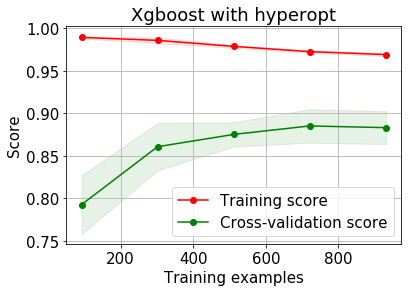

In [85]:
plot_learning_curve(X=train_x, y = train_y, estimator=xgb_hyperopt, cv=5, title="Xgboost with hyperopt")

In [50]:
xgb_hyperopt.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9571147650613927, eval_metric='rmse',
       gamma=0.0003474286519319983, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=6, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.4484691959143669, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.925033308124534)

In [51]:
print(np.sqrt(mean_squared_error(y_pred=xgb_hyperopt.predict(dev_x), y_true=dev_y)))

0.04513103566464955
